<a href="https://colab.research.google.com/github/Ranga-Kulathunga/EN-4353-Radar-and-Navigation/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EN 4353 - Radar and Navigation - Assignment 03

### Topic: Monostatic MTD Surveillance Radar
### Name: I.G.R.M. Kulathunga
### Index: 170318X

Link to Colab Notebook: https://colab.research.google.com/drive/11XD2t9rx0iR1fwP_PCHi31CzEucjuqMC?usp=sharing

# Initialization

## Import Libraries and Load the Data Files

In [66]:
# import libraries
import pandas as pd
import io as io
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('default')

# load .csv file
path = 'https://dms.uom.lk/s/tbgSXj2yfSANXae/download' 
df = pd.read_csv(path)

## Define Parameters

* Pulse Repetition Interval (PRI):
>$T_r = 900\;\mu s$

* Actual pulse transmission and receiption time:
>$T_{actual} = 600\;\mu s$

* Transmit pulse width:
>$T_0 = 14\;\mu s$

* Azimuth Counter Pulses (ACP) during one complete revolution:
>$n_{ACP} = 4096$

* Number of samples per one cycle of ACP:
>$n = 22500$

* Number of Coherence Processing Intervals (CPIs) during one complete revolution:
>$n_{CPI} = 128$

* Ratio between number of ACPs and CPIs during one complete revolution:
>$\frac{n_{ACP}}{n_{CPI}} = 32$

* Sampling Frequency: 
>$F_s = 4\;MHz$

In [67]:
# define parameters
T_r = 900 # us
T_actual = 600 # us
T_0 = 14 # us

n_ACP = 4096
n = 22500
n_CPI = 128

F_s = 4 # MHz

# Question 01

In [68]:
df.head(20)

,Sample Number,I-CH,Time,Q CH,ACP
0,-524288,7F7B,-26.214308 ms,FF76,0
1,-524287,7F7B,-26.214258 ms,FF76,0
2,-524286,7F7B,-26.214208 ms,FF76,0
3,-524285,7F7B,-26.214158 ms,FF76,0
4,-524284,7F7B,-26.214108 ms,FF76,0
5,-524283,7F6A,-26.214058 ms,FF77,0
6,-524282,7F6A,-26.214008 ms,FF77,0
7,-524281,7F6A,-26.213958 ms,FF77,0
8,-524280,7F6A,-26.213908 ms,FF77,0
9,-524279,7F6A,-26.213858 ms,FF77,0


* Given oversampled data shows that the same value is repeated five times as the printed values above.
>$Oversampling\:\:Factor = 5$

* Data is converted into normal sampling frequency $F_s = 4\;MHz$ after downsampling.

### Downsampling

In [69]:
def down_sample(signal, factor):
  # shaping the signal
  if(~len(signal)%factor):
    rest = np.zeros(factor-len(signal)%factor).astype('str')
    signal = np.append(signal, rest)

  signal_mat = signal.reshape(int(len(signal)/factor), factor)

  # select 0th column of signal matrix
  sampled_signal =  signal_mat[:, 0]

  return sampled_signal

In [70]:
os_factor = 5; # oversampling factor

# convert data into np arrays
I_CH_np = df['I-CH'].to_numpy()
Q_CH_np = df['Q CH'].to_numpy()
time_np = df['Time'].to_numpy()

# perform downsampling and remove first 10650 samples
I_CH = down_sample(I_CH_np, os_factor)[10650:]
Q_CH = down_sample(Q_CH_np, os_factor)[10650:]
time = down_sample(time_np, os_factor)[10650:]
time_axis = np.vectorize(lambda x: x[:len(x)-3:1], otypes=[float])(time)


### $I$ - channel correction
* First hex value of $I-CH$ = **7** => replace by **F**

In [71]:
def i_ch_corr(ch):
  new_ch = []
  for val in (I_CH):
    if val[0]=='7':
      corr = 'F' + val[1:]
    else:
      corr = val
    new_ch.append(corr)

  return np.array(new_ch)

In [72]:
I_CH_corr = i_ch_corr(I_CH)

### Conversion from hexadecimal to signed integers

Data is stored as 16-bits 2's complement numbers in hex format.

In [73]:
def hex2dec(hex, bits):
  value = int(hex, bits)
  if (value & (1 << (bits - 1))) != 0: 
    value = value - (1 << bits)  
  return value

array_1 = []
for i in I_CH_corr:
  array_1.append(hex2dec(i, 16))

array_2 = []
for q in Q_CH:
  array_2.append(hex2dec(q, 16))

I_CH_proc = np.array(array_1)
Q_CH_proc = np.array(array_2)

# Question 02

 Complex radar receiver response signal is,
 >$W(t) = I(t) + jQ(t)$

 where, $I(t)$ and $Q(t)$ are in-phase and quadrature channel components respectively.

In [74]:
W = I_CH_proc + 1j*Q_CH_proc

sample_size = T_r*F_s # 900us*4MHz = 3600 samples
dataMatrix = W[:int(len(W)/sample_size)*sample_size].reshape(int(len(W)/sample_size), sample_size)

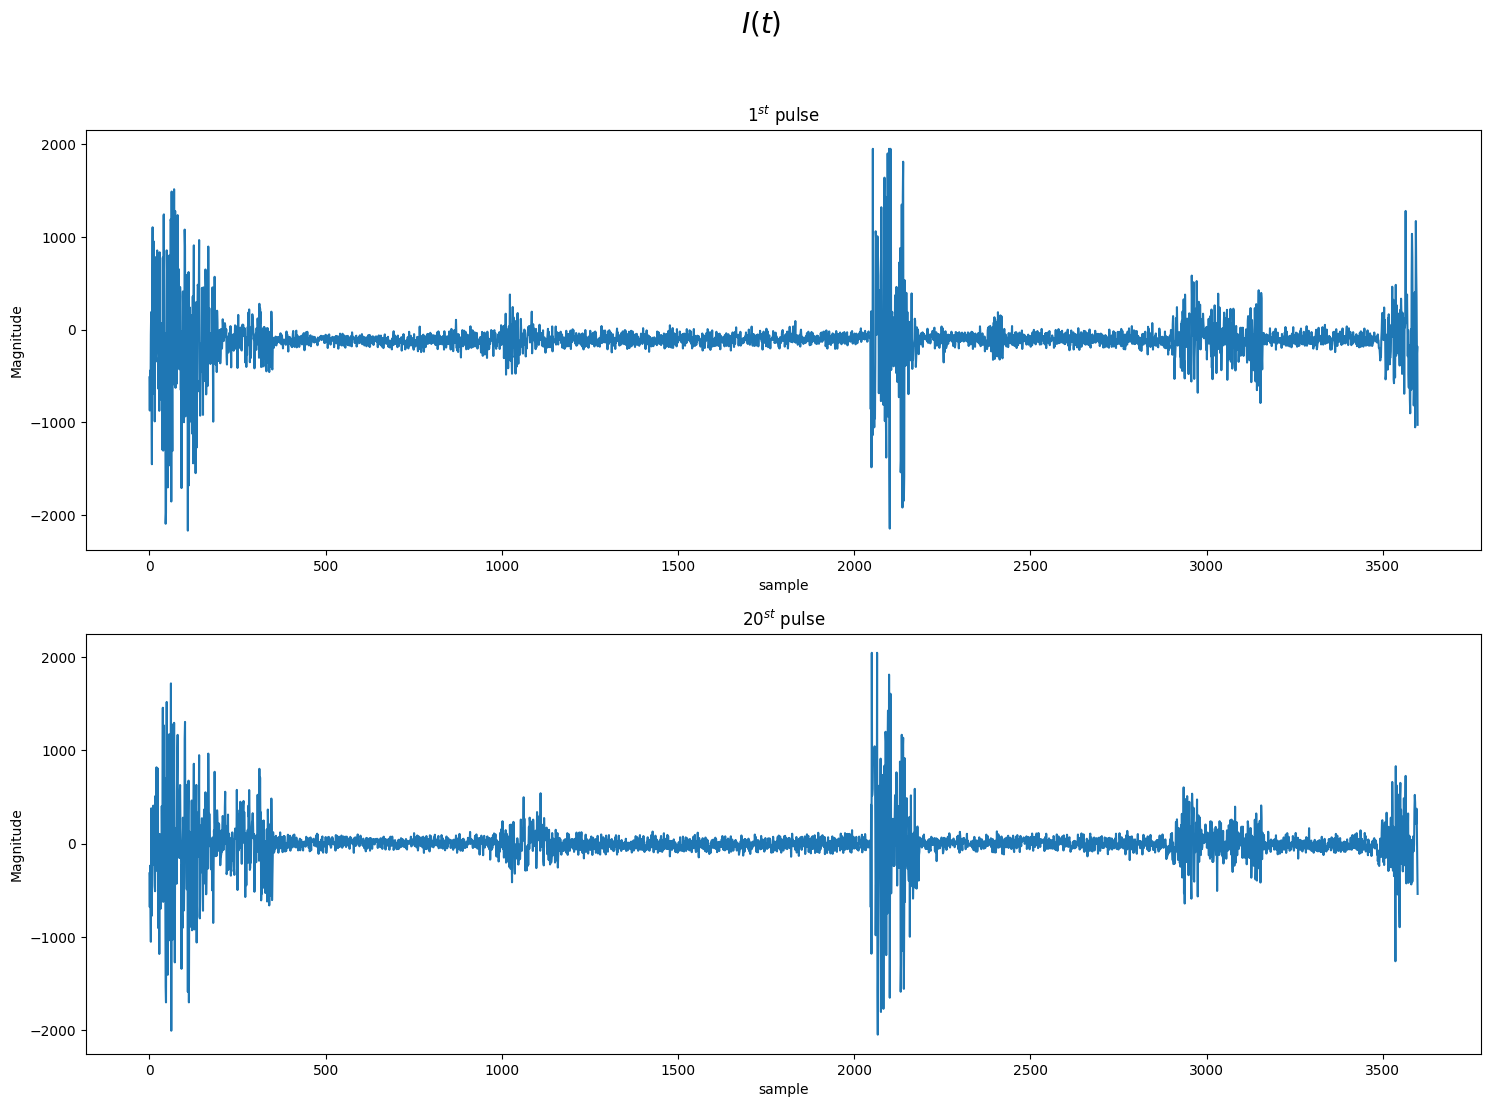

In [75]:
# plot I(t) for the 1st and 20th pulses as subplots

f, [ax1, ax2] = plt.subplots(2, 1, figsize=(18,12))
f.suptitle('$I(t)$', fontsize = 20)

ax1.plot(np.real(dataMatrix[0]))
ax1.set_title('$1^{st}$ pulse')
ax1.set(xlabel='sample', ylabel='Magnitude')

ax2.plot(np.real(dataMatrix[19]))
ax2.set_title('$20^{st}$ pulse')
ax2.set(xlabel='sample', ylabel='Magnitude')
plt.show()

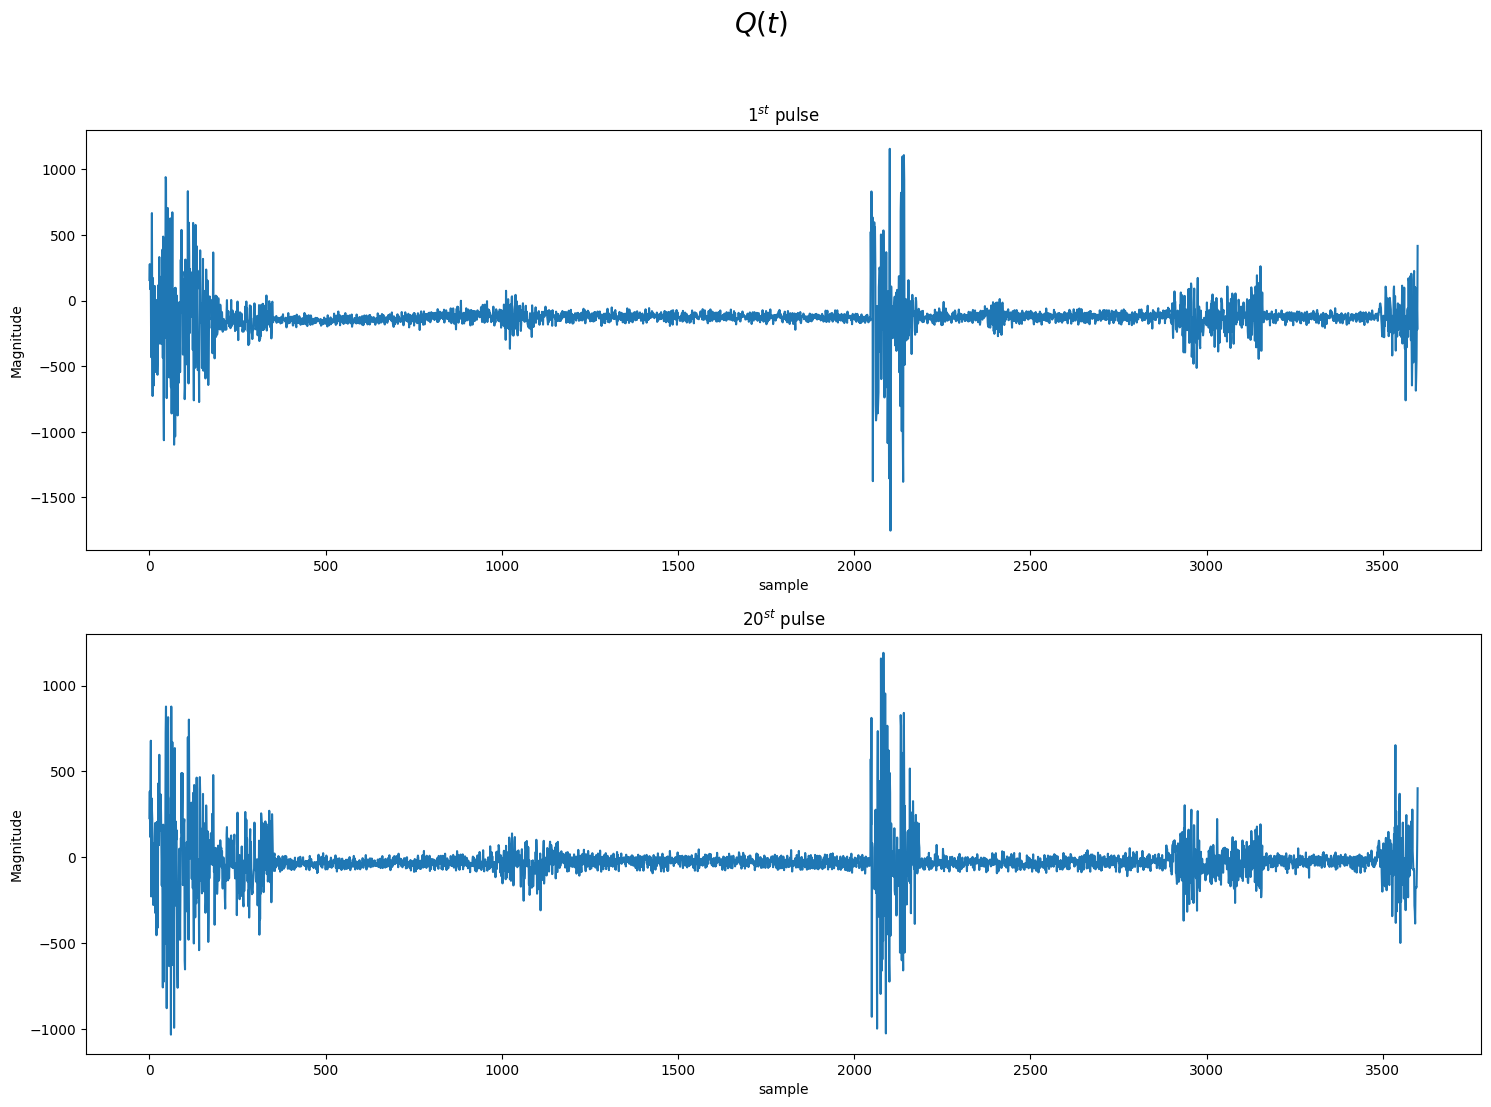

In [76]:
# plot Q(t) for the 1st and 20th pulses as subplots

f, [ax1, ax2] = plt.subplots(2, 1, figsize=(18,12))
f.suptitle('$Q(t)$', fontsize = 20)

ax1.plot(np.imag(dataMatrix[0]))
ax1.set_title('$1^{st}$ pulse')
ax1.set(xlabel='sample', ylabel='Magnitude')

ax2.plot(np.imag(dataMatrix[19]))
ax2.set_title('$20^{st}$ pulse')
ax2.set(xlabel='sample', ylabel='Magnitude')
plt.show()

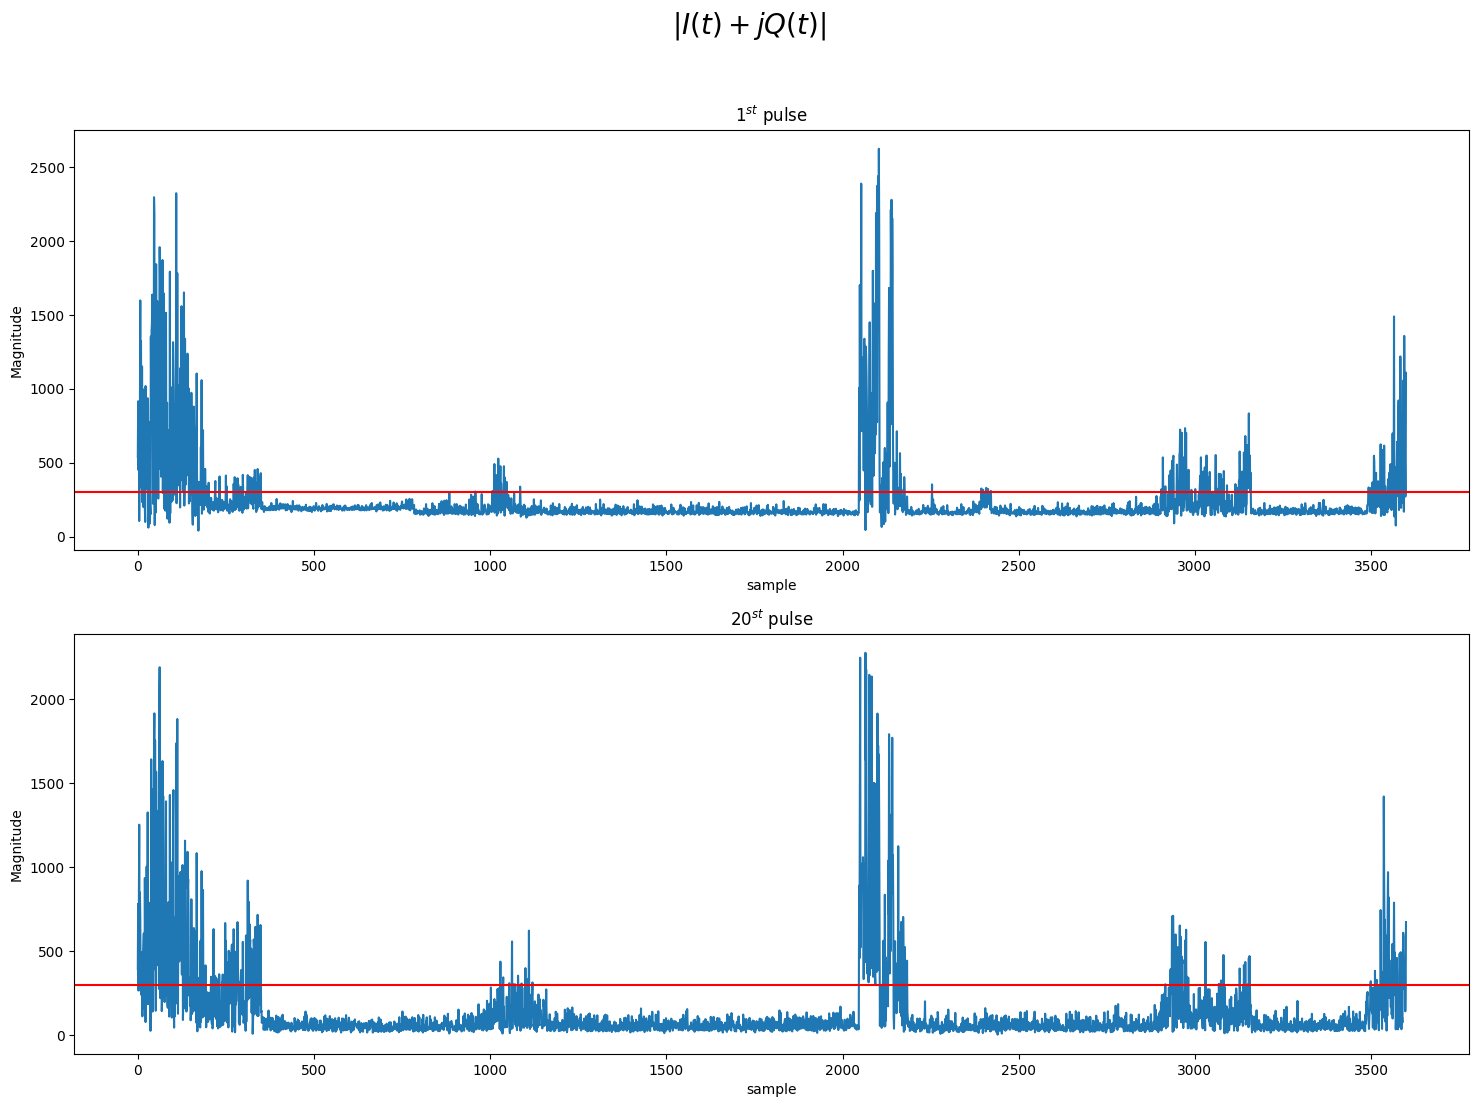

In [77]:
# plot |I(t)+jQ(t)| for the 1st and 20th pulses as subplots

f, [ax1, ax2] = plt.subplots(2, 1, figsize=(18,12))
f.suptitle('$|I(t)+jQ(t)|$', fontsize = 20)

ax1.plot(np.abs(dataMatrix[0]))
ax1.set_title('$1^{st}$ pulse')
ax1.set(xlabel='sample', ylabel='Magnitude')
ax1.axhline(y=300, color='r', linestyle='-')

ax2.plot(np.abs(dataMatrix[19]))
ax2.set_title('$20^{st}$ pulse')
ax2.set(xlabel='sample', ylabel='Magnitude')
ax2.axhline(y=300, color='r', linestyle='-')
plt.show()

# Question 03

* By observing the above plots of 1st and 20th pulses, the threshold can be defined as,
> Threshold = 300

In [78]:
TH = 300

# Question 04

* 3600 samples for one pulse of length of $T_r = 900\: \mu s$
* Let consider the data from $T_0 = 14\:\mu s$ to $T_{actual} = 600\:\mu s$ for each pulse period by removing blind period and processing time
* Hence, samples for each pulse are considered from $56^{th}$ sample to $2400^{th}$ sample since,
>$T_0\times F_s=14\:\mu s \times 4\:MHz = 56$ \\
>$T_{actual} \times F_s = 600\:μ s \times 4\:MHz = 2400$
* Then, filter the considered data samples using the threshold defined in Question 02.

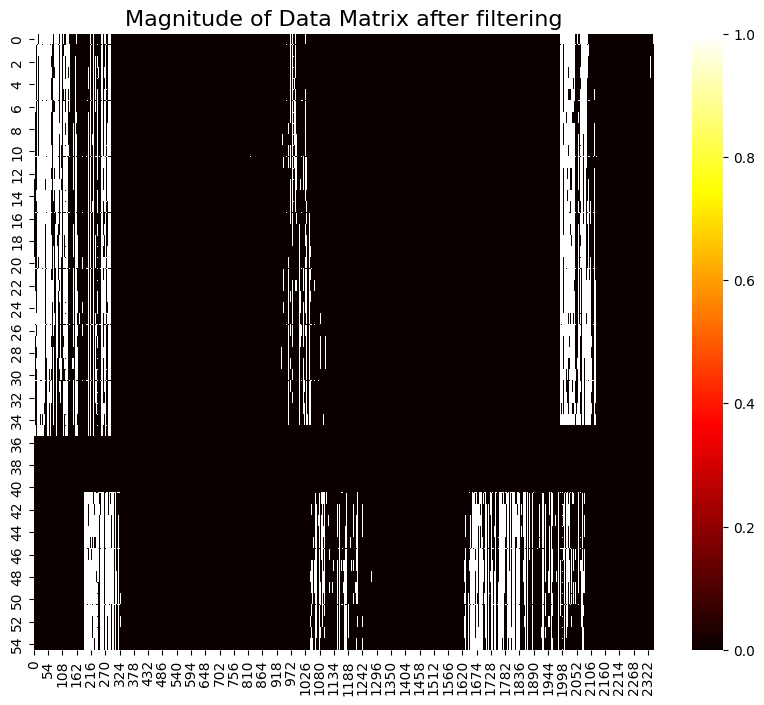

In [79]:
# define range
l_lim = T_0*F_s
u_lim = T_actual*F_s

# visualization of selected part of the data matrix after filtering
f, ax = plt.subplots(figsize=(10,8))
plt.title("Magnitude of Data Matrix after filtering", fontsize = 16)
ax = sns.heatmap(np.abs(dataMatrix[:, l_lim:u_lim])>TH, square=False, annot=False, cmap="hot", cbar=True)

# Question 05

**1.   RPM of the Radar**

In [80]:
fs = os_factor*F_s # sampling frequency of received echoes = oversampling factor x Fs
t_ACP = n/(fs*10**6) # time per ACP = samples per ACP x sampling period of received echoes
T = n_ACP*t_ACP # time per revolution = number of ACPs per rev. x time per ACP

rpm = 60/T # rotational frequency of the radar in rpm

print("RPM of the Radar = ", rpm, " rpm")

RPM of the Radar =  13.020833333333334  rpm


**2.   Number of ehoes per CPI interval**

In [81]:
n_echo_ACP = n/(T_r*fs) # number of echoes per ACP = samples per ACP/samples per echo
ACP2CPI = n_ACP/n_CPI # ACPs per CPI

echoes2CPI = ACP2CPI*n_echo_ACP # number of echoes per CPI = ACPs per CPI x number of echoes per ACP

print("Number of echoes per CPI interval = ", echoes2CPI)

Number of echoes per CPI interval =  40.0


**3.   Beam width of the Radar**

* A CPI forms one azimuth bin that corresponds with the antenna beamwidth

In [82]:
res = 360/n_ACP # resolution of shaft encoder = rotation per ACP

bw = ACP2CPI*res # one azimuth bin is formed by one CPI

print("Beam width of the Radar = ", bw, " deg")

Beam width of the Radar =  2.8125  deg


> RPM of the Radar = 13.0208 rpm

> Number of echoes per CPI interval = 40

> Beam width of the Radar = 2.8125°



# Question 06

### Observation 01

* There are three different regions in clutter map obtained in Question 04 as shown below.
>**Region 1:** Only contains clutter since we were given no moving targets \\
>**Region 2:** No received sinal with power greater than threshold. \\
>**Region 3:** Contains clutter map with a shift from the clutter map in Region 1.

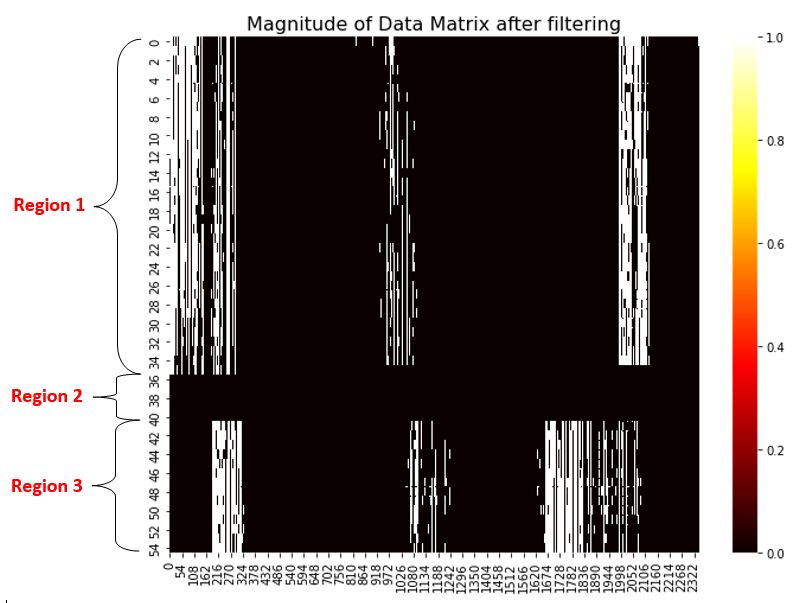

* Assume that the radar is rotating at a constant speed because the shaft encoder provides pulses with same frequency.
* Although the surrounding of the radar is changed, significant change of the received data cannot be expected since change of the azimuth is negligible.
* Possible reasons for the difference of Region 2:
>- The malfunctionality of the transmitter does not illuminate the radar vicinity properly. \\
>- Tramitter is turned off during that period.

* Possible reasons for the difference of Region 3:
>- Let assume that the reason for region 2 is trasmitter is turned off during that period. Transmitter is turned on again in-between $T_r = 900\:\mu s$ interval. This reason is further describe below.



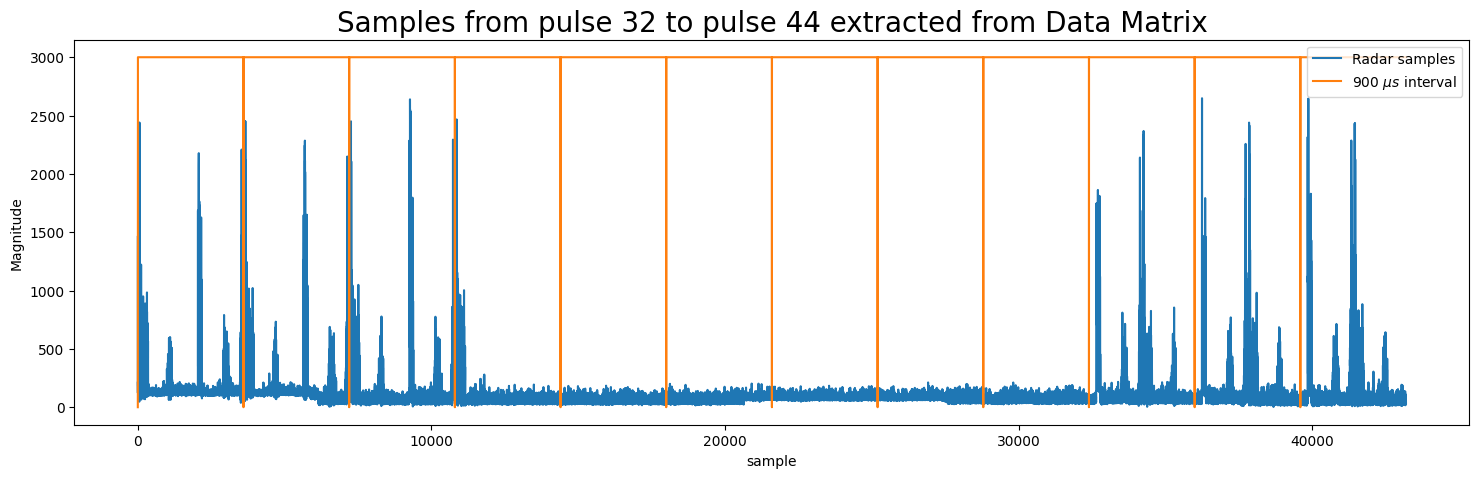

In [83]:
f,ax = plt.subplots(figsize=(18,5))
plt.plot(np.abs(W)[32*sample_size:44*sample_size], label='Radar samples')

pulse = np.zeros(len(W))
for i in range(len(W)):
  if i%sample_size:
    pulse[i]=3000

plt.plot(pulse[32*sample_size:44*sample_size], label='900 $\mu s$ interval')

ax.set_title('Samples from pulse 32 to pulse 44 extracted from Data Matrix', fontsize=20)
ax.set(xlabel='sample', ylabel='Magnitude')
plt.legend(loc='upper right')
plt.show()

* Sampling of the signal is differ from Region 1 in Region 3 so the shift of the clutter map can be expected.
* The above plot shows that the transmitter is turned on in-between $T_r = 900\:\mu s$ interval so that could be a reason for the clutter map to be shifted in Region 3.
* To overcome this issue by synchronizing samples with ACP encoder, we can remove the samples related to the shift and can use resultant data set for MTD. This modification does not affects for the processing of the detection.

### Observation 02

* Additionally, we can see another difference when we plot time axis of the data set.

Text(0, 0.5, 'time (ms)')

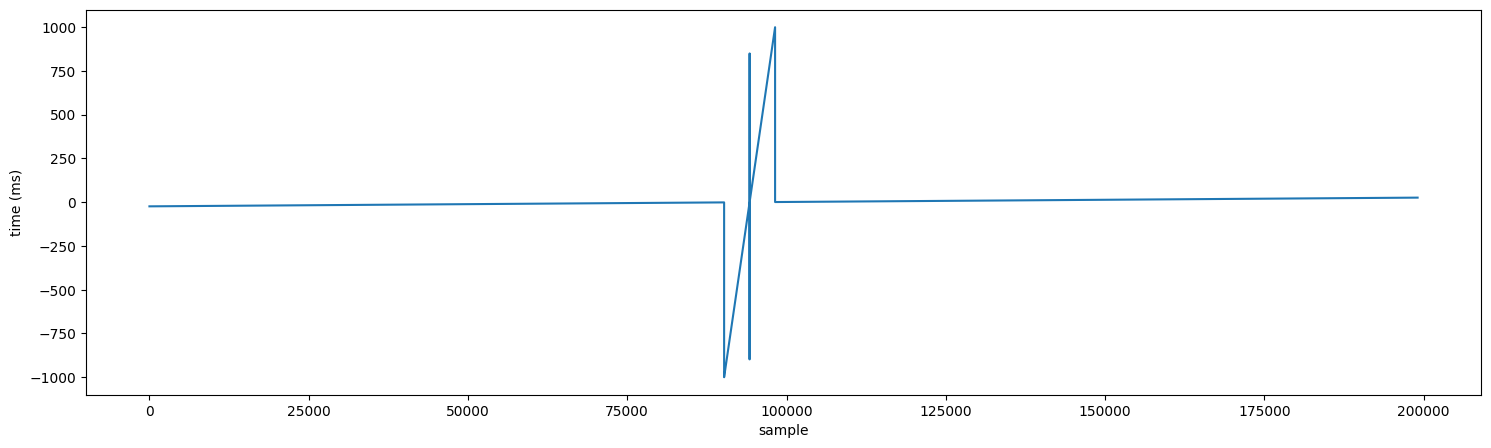

In [84]:
f, ax = plt.subplots(figsize=(18,5))
plt.plot(time_axis)
plt.xlabel('sample')
plt.ylabel('time (ms)')

* Sudden surge occurs around sample 90000.
* Reason would be the malfunctioning with system clock since observed pulses have the expected periodicity.